# Single Subject GLM Analysis using the Localizer dataset

In this lab, extend your work from the previous lab to work with 3D brain data. The preprocessed data of the first subject in the localizer study is included.

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import sin, pi, arange
from nltools.external import glover_hrf

%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nib

import scipy.misc
from scipy import ndimage
from ipywidgets import interact_manual, interact

Load the functional image of the first subject.

In [3]:
data = nib.load('preprocessed_fMRI_bold.nii.gz')

We should get a sequence of 128 frames of 3D images of the shape (53, 63, 46).

In [4]:
data.get_fdata().shape

(53, 63, 46, 128)

Let's plot a few brain slices just to check if we are actually seeing some brain.

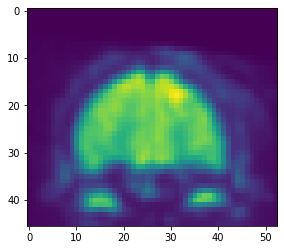

In [5]:
# Note: Shawn rotated it 90 degrees
plt.imshow(ndimage.rotate(data.get_fdata()[:,55,:,10], 90))

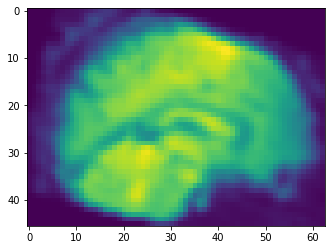

In [6]:
# Note: Shawn rotated it 90 degrees
plt.imshow(ndimage.rotate(data.get_fdata()[25,:,:,0], 90))

Let's load the mask data for this subject.

In [7]:
mask = nib.load('./sub-S01_mask.nii.gz')

The shape of the mask data should be identical to that of a signle frame in the brain data.

In [8]:
mask.get_fdata().shape

(53, 63, 46)

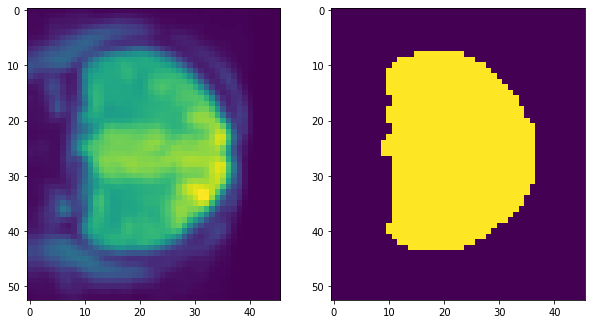

In [9]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[:,50,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[:,50,:])

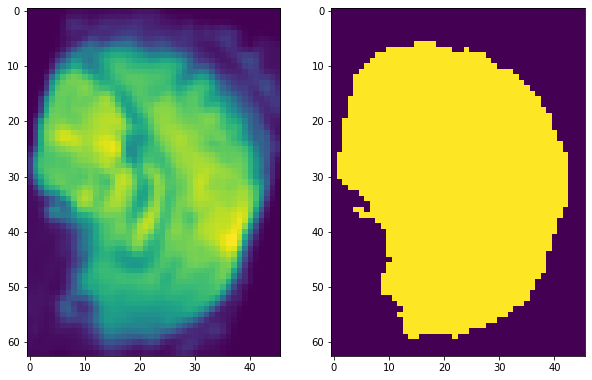

In [10]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[25,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[25,:,:])

# Exercise 

For each of the question below, use your code to perform the analysis.

First, we need the localizer study data

In [11]:
# (seconds)
total_scan_time = 300 # five minutes

# (milliseconds)
onset_times = [0,2400,5700,8700,11400,15000,18000,20700,23700,26700,29700,33000,35400,39000,41700,44700,48000,
        50700,53700,56400,59700,62400,66000,69000,71400,75000,78000,80400,83400,87000,89700,93000,96000,
        99000,102000,105000,108000,110400,113700,116700,119400,122700,125400,129000,131400,135000,137700,
        140400,143400,146700,149400,153000,156000,159000,162000,164400,167700,170400,173700,176700,179700,
        182700,186000,188400,191700,195000,198000,201000,203700,207000,210000,212700,215700,218700,221400,
        224700,227700,230700,234000,236700,240000,243000,246000,248400,251700,254700,257400,260400,264000,
        266700,269700,272700,275400,278400,281700,284400,288000,291000,293400,296700]

# onset type (one-based index)
onset_types = [8,8,11,1,3,10,5,10,4,6,10,2,7,9,9,7,7,11,11,9,
        1,4,11,5,6,9,11,11,7,3,10,11,2,11,11,11,7,11,11,6,
        10,2,8,11,9,7,7,2,3,10,1,8,2,9,3,8,9,4,7,1,
        11,11,11,1,7,9,8,8,2,2,2,6,6,1,8,1,5,3,8,10,
        11,11,9,1,7,4,4,8,2,1,1,11,5,2,11,10,9,5,10,10]

localizer_labels = ['horizontal_checkerboard',
          'vertical_checkerboard',
          'motor_right_auditory',          
          'motor_left_auditory',
          'motor_right_visual',          
          'motor_left_visual',
          'subtraction_auditory',
          'subtraction_visual',          
          'sentence_visual',   
          'sentence_auditory']

def get_localizer_design_data():

    # onset type
    onset_types_0_based = np.array(onset_types) - 1
    
    events = list(zip(onset_times, onset_types_0_based))
    
    # ignore the last onset type
    events = [(onset_time, onset_type) for (onset_time, onset_type) in events if onset_type != 10]
    
    return (events, localizer_labels)

events, labels = get_localizer_design_data()

## NEW LAB STUFF

Next, we need the reusable code from our separate module

In [12]:
import glm_code 
import importlib
importlib.reload(glm_code)

<module 'glm_code' from '/Users/shawnpolson/Documents/School/Spring 2020/Brain AI/bai-book/content/labs/lab-glm_3d/glm_code.py'>

- 3D Convolution to merge nearby clusters (/)
- Find clusters (/)
- Find cluster centers (/)
- Slider to explore clusters (/)
- Offload reusable code into seperate module (/)

## 3D Convolution to merge nearby clusters

In [13]:
data_copy = glm_code.get_orig_data().get_fdata()
data_convolved = glm_code.smooth(data_copy)

#print(data_convolved)

## Find clusters

In [14]:
data = glm_code.get_orig_data()
mask = glm_code.get_orig_mask().get_fdata()
design_matrix = glm_code.get_localizer_design_matrix()
contrast_vector = glm_code.contrast_vector_from_name(design_matrix, "visual", "aud")

# Takes a while to compute
beta_map_visual_vs_aud = glm_code.compute_beta_map(data, design_matrix.values)

In [15]:
threshold = 0.1
brain_processed = glm_code.get_contrast_thresholded(beta_map_visual_vs_aud, contrast_vector, mask, threshold)
# 3D convolution to merge nearby clusters
brain_processed = glm_code.smooth(brain_processed, 0.2) 

clustered_data, num_clusters = glm_code.find_clusters(brain_processed) # labeled_img, num_labels = ndimage.label(data)
print(clustered_data.shape)
print(num_clusters)

(53, 63, 46)
6


## Find cluster centers

In [17]:
centers = ndimage.measurements.center_of_mass(brain_processed, clustered_data, np.arange(num_clusters))
centers

[(nan, nan, nan),
 (nan, nan, nan),
 (16.797741467896792, 20.809522007080684, 24.201710086924393),
 (25.773002499992863, 34.47610705310264, 18.478800300084146),
 (25.351241553078037, 22.975978718344614, 7.5981114667654035),
 (35.999999999999986, 17.5103466856994, 11.489653314300591)]

## Slider to explore clusters

In [18]:
@interact(cluster=(0,len(centers)-1))
def interact_with_clusters(cluster=2):
    xStart, yStart, zStart, data = glm_code.get_default_xyz_and_data_for_cluster(brain_processed, clustered_data, cluster)
    @interact(x=(0,52), y=(0,62), z=(0,45))
    def plot_clusters(x=xStart, y=yStart, z=zStart):
        glm_code.ShowLocationWithMask(data, mask, x, y, z)

interactive(children=(IntSlider(value=2, description='cluster', max=5), Output()), _dom_classes=('widget-inter…